# Competitive Auctions on eBay.com

## eBay.com의 경쟁적인 경매

- [eBayAuction.csv] 파일에는 2004년 5~6월에 eBay.com에서 거래된 총 1,972건의 경매 정보가 담겨 있다. 분석 목적은 이 데이터를 사용해 경쟁적인 경매와 비경쟁적인 경매를 구분하는 모델을 구축하는 것이다.

- 경쟁적인 경매는 경매되고 있는 물품에 대해 최소한 2개 이상의 입찰이 있는 경매로 정의된다. 데이터는 물품을 나타내는 변수(경매 범주), 판매자 등급(eBay 등급), 판매자가 선택한 경매 조건(경매 기간, 시작가(OpenPrice), 화폐 단위, 경매 마감 요일)을 포함한다. 경매가 마감된 가격(ClosePrice)에 대한 데이터도 있다. 분석 목표는 경매가 경쟁적인지 아닌지를 예측하는 것이다.

- 데이터 전처리: 범주형 예측 변수들에 대해서 더미 변수를 생성하시오. 범주형 변수에는 물품 항목(Category: 18개 범주), 화폐 단위(currency: US, GBP, EUR), 경매 종료일(endDay: 월요일~일요일), 경매 기간(Duration: 1, 3, 5, 7, 10일)이 포함된다.

In [14]:
'''
eBayAuctions.csv파일을 읽어 DataFrame 생성
'''
import pandas as pd

eBayAuctions_df = pd.read_csv('../data/eBayAuctions.csv')
eBayAuctions_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,Automotive,US,2992,5,Sun,359.95,359.95,0
1968,Automotive,US,21,5,Sat,610.00,300.00,1
1969,Automotive,US,1400,5,Mon,549.00,549.00,0
1970,Automotive,US,57,7,Fri,820.00,650.00,1


In [15]:
'''
범주형 예측 변수들에 대해서 더비 변수 생성
범주형 변수: Category, currency, endDay, Duration
'''
from sklearn.preprocessing import LabelEncoder

preprocessed_df = eBayAuctions_df.copy()
le = LabelEncoder()
preprocessed_df['Category'] = le.fit_transform(preprocessed_df['Category'])
preprocessed_df['currency'] = le.fit_transform(eBayAuctions_df['currency'])
preprocessed_df['endDay'] = le.fit_transform(eBayAuctions_df['endDay'])
preprocessed_df['Duration'] = le.fit_transform(eBayAuctions_df['Duration'])
preprocessed_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,13,2,3249,2,1,0.01,0.01,0
1,13,2,3249,2,1,0.01,0.01,0
2,13,2,3249,2,1,0.01,0.01,0
3,13,2,3249,2,1,0.01,0.01,0
4,13,2,3249,2,1,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,1,2,2992,2,3,359.95,359.95,0
1968,1,2,21,2,2,610.00,300.00,1
1969,1,2,1400,2,1,549.00,549.00,0
1970,1,2,57,3,0,820.00,650.00,1


---
- 다양한 범주형 변수들(더미 변수가 아닌 원래 변수 사용)의 함수로서 이진형 결과 변수(경쟁적인 경매 여부)의 평균을 구하기 위해 피벗 테이블을 작성하시오. 모델에서 사용될 더비 변수의 개수를 줄이기 위해서 피벗 테이블의 정보를 활용하시오. 예를 들어, 경쟁적인 경매의 분포가 유사한 범주는 합칠 수 있다.

## Category(카테고리)
[eBay.com - Category](https://www.ebay.com/n/all-categories)

- Antique/Art/Craft      앤틱/미술/공예   
- Automotive             자동차   
- Books                  책   
- Business/Industrial    비즈니스/산업   
- Clothing/Accessories   옷/악세사리   
- Coins/Stamps           동전/우표   
- Collectibles           수집물   
- Computer               컴퓨터   
- Electronics            전자기기   
- EverythingElse         이외의 것들   
- Health/Beauty          헬스/뷰티   
- Home/Garden            홈/가든   
- Jewelry                쥬얼리   
- Music/Movie/Game       음악/영화/게임   
- Photography            사진   
- Pottery/Glass          도자기/글라스   
- SportingGoods          운동용품   
- Toys/Hobbies           장난감/취미   

                      Competitive?
Category                          
Antique/Art/Craft         0.564972
Automotive                0.353933
Books                     0.500000
Business/Industrial       0.666667
Clothing/Accessories      0.504202
Coins/Stamps              0.297297
Collectibles              0.577406
Computer                  0.666667
Electronics               0.800000
EverythingElse            0.235294
Health/Beauty             0.171875
Home/Garden               0.656863
Jewelry                   0.365854
Music/Movie/Game          0.602978
Photography               0.846154
Pottery/Glass             0.350000
SportingGoods             0.725806
Toys/Hobbies              0.529915


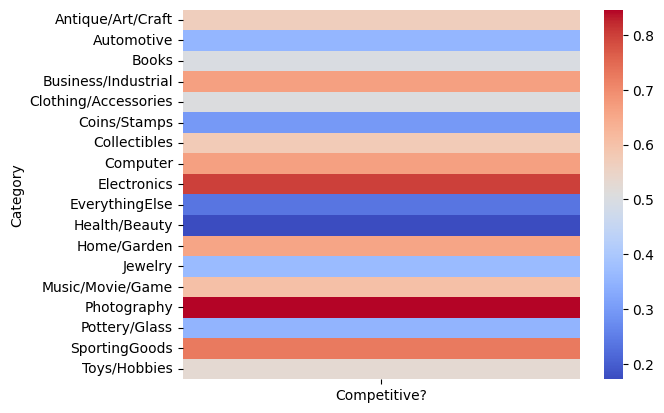

In [16]:
# 시각화 (seaborn 라이브러리 사용)
import seaborn as sns
import matplotlib.pyplot as plt

Category_pivot = eBayAuctions_df.pivot_table(index='Category', values='Competitive?', aggfunc='mean')
print(Category_pivot)
# heatmap 시각화
sns.heatmap(Category_pivot, cmap='coolwarm')
plt.show()

                                                    Competitive?
MergedCategory                                                  
Books+Clothing/Accessories+Toys/Hobbies+Antique...      0.564437
Coins/Stamps                                            0.297297
Electronics+Photography                                 0.808824
EverythingElse                                          0.235294
Health/Beauty                                           0.171875
Home/Garden+Computer+Business/Industrial                0.660256
Pottery/Glass+Automotive+Jewelry                        0.357143
SportingGoods                                           0.725806


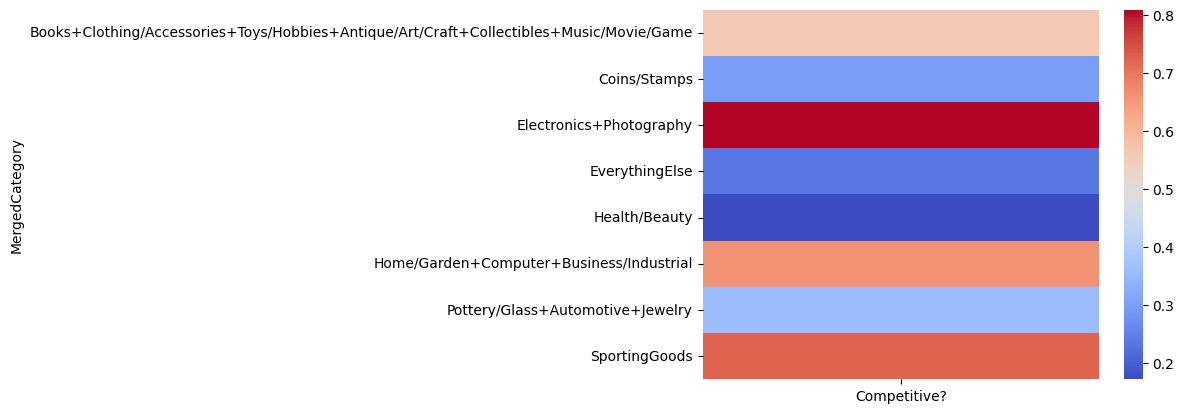

In [45]:
import pandas as pd
import numpy as np

# 데이터프레임 생성 (샘플 데이터)
eBayAuctions_df

# 범주별 평균값 계산
category_means = eBayAuctions_df.groupby("Category")["Competitive?"].mean()

# 오차 범위 내 병합을 위한 함수
def merge_categories(category_means, tolerance=0.05):
    category_means = category_means.sort_values()  # 오름차순 정렬
    groups = []  # 병합 결과 저장
    current_group = []
    current_mean = None

    for category, mean in category_means.items():
        if current_group and abs(current_mean - mean) > tolerance:
            groups.append(current_group)
            current_group = []
        current_group.append(category)
        current_mean = mean
    if current_group:
        groups.append(current_group)

    # 병합된 그룹 반환 (카테고리 이름들을 "-"로 연결)
    return {cat: "+".join(group) for group in groups for cat in group}

# 병합된 그룹 생성
merged_groups = merge_categories(category_means)

# 데이터프레임에 병합된 그룹 추가
eBayAuctions_df["MergedCategory"] = eBayAuctions_df["Category"].map(merged_groups)

merged_Category_pivot = eBayAuctions_df.pivot_table(index='MergedCategory', 
                                       values='Competitive?', 
                                       aggfunc='mean')
print(merged_Category_pivot)
# heatmap 시각화
sns.heatmap(merged_Category_pivot, cmap='coolwarm')
plt.show()

---
# currency(통화)
- EUR: 유로
- GBP: 파운드 스털링(영국 외 9개 국가)
- US: 달러

          Competitive?
currency              
EUR           0.551595
GBP           0.687075
US            0.519350


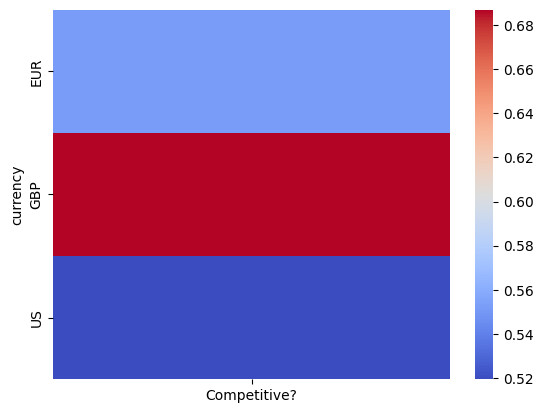

In [17]:
currency_pivot = eBayAuctions_df.pivot_table(index='currency', values='Competitive?', aggfunc='mean')
print(currency_pivot)
# heatmap 시각화
sns.heatmap(currency_pivot, cmap='coolwarm')
plt.show()

---
## endDay(경매 종료일)
- Monday
- Tuesday
- Wednsday
- Thursday
- Friday
- Saturday
- Sunday

        Competitive?
endDay              
Fri         0.466899
Mon         0.673358
Sat         0.427350
Sun         0.485207
Thu         0.603960
Tue         0.532164
Wed         0.480000


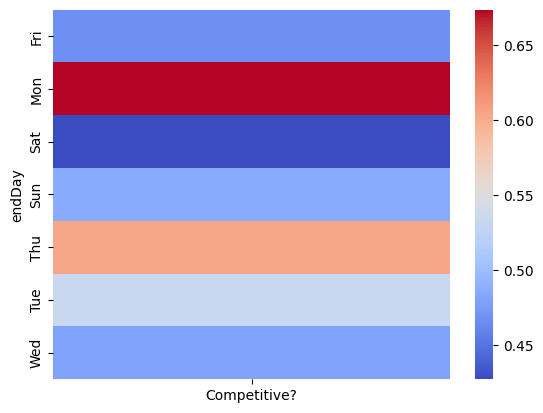

In [18]:
endDay_pivot = eBayAuctions_df.pivot_table(index='endDay', values='Competitive?', aggfunc='mean')
print(endDay_pivot)
# heatmap 시각화
sns.heatmap(endDay_pivot, cmap='coolwarm')
plt.show()

               Competitive?
Merged_endDay              
Fri+Wed+Sat        0.474965
Mon                0.618572
Sun                0.516929
Thu                0.591013
Tue                0.551260


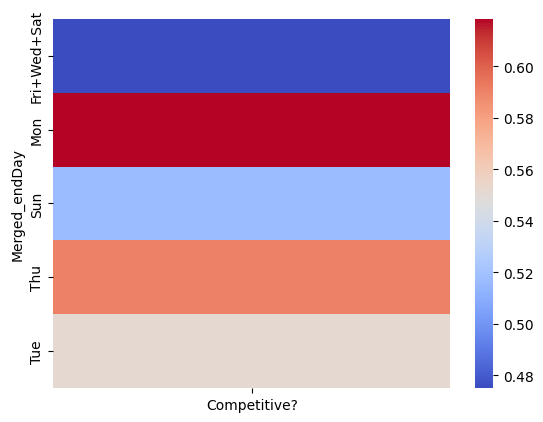

In [46]:
import pandas as pd
import numpy as np

eBayAuctions_df

# 범주별 평균값 계산
endDay_means = eBayAuctions_df.groupby("endDay")["Competitive?"].mean()

# 병합된 그룹 생성
merged_groups = merge_categories(endDay_means, 0.02)

# 데이터프레임에 병합된 그룹 추가
eBayAuctions_df["Merged_endDay"] = eBayAuctions_df["endDay"].map(merged_groups)

merged_endDay_pivot = eBayAuctions_df.pivot_table(index='Merged_endDay', 
                                                  values='Competitive?', 
                                                  aggfunc='mean')
print(merged_endDay_pivot)
# heatmap 시각화
sns.heatmap(merged_endDay_pivot, cmap='coolwarm')
plt.show()

---
## Duration(경매기간)
- 1
- 3
- 5
- 7
- 10

          Competitive?
Duration              
1             0.521739
3             0.450704
5             0.686695
7             0.489142
10            0.544554


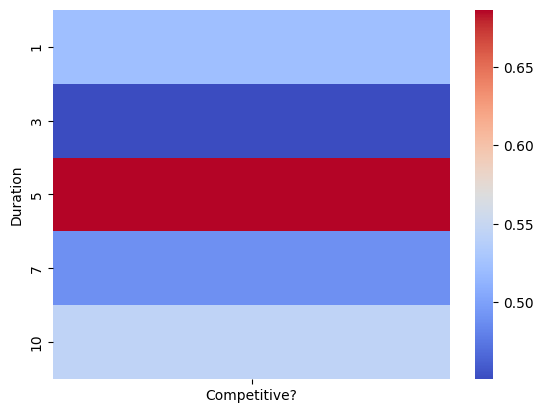

In [13]:
Duration_pivot = eBayAuctions_df.pivot_table(index='Duration', values='Competitive?', aggfunc='mean')
print(Duration_pivot)
# heatmap 시각화
sns.heatmap(Duration_pivot, cmap='coolwarm')
plt.show()

In [47]:
'''
범주형 예측 변수들에 대해서 더비 변수 생성
범주형 변수: Category, currency, endDay, Duration
'''
from sklearn.preprocessing import LabelEncoder

preprocessed_df = eBayAuctions_df.copy()
le = LabelEncoder()
preprocessed_df['Category'] = le.fit_transform(preprocessed_df['Category'])
preprocessed_df['currency'] = le.fit_transform(eBayAuctions_df['currency'])
preprocessed_df['endDay'] = le.fit_transform(eBayAuctions_df['endDay'])
preprocessed_df['Duration'] = le.fit_transform(eBayAuctions_df['Duration'])
preprocessed_df['MergedCategory'] = le.fit_transform(eBayAuctions_df['MergedCategory'])
preprocessed_df['Merged_endDay'] = le.fit_transform(eBayAuctions_df['Merged_endDay'])
preprocessed_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,Group,MergedCategory,Merged_endDay
0,13,2,3249,2,1,0.01,0.01,0.602978,Music/Movie/Game,0,1
1,13,2,3249,2,1,0.01,0.01,0.602978,Music/Movie/Game,0,1
2,13,2,3249,2,1,0.01,0.01,0.602978,Music/Movie/Game,0,1
3,13,2,3249,2,1,0.01,0.01,0.602978,Music/Movie/Game,0,1
4,13,2,3249,2,1,0.01,0.01,0.602978,Music/Movie/Game,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1967,1,2,2992,2,3,359.95,359.95,0.000000,Automotive,6,2
1968,1,2,21,2,2,610.00,300.00,1.000000,Automotive,6,0
1969,1,2,1400,2,1,549.00,549.00,0.000000,Automotive,6,1
1970,1,2,57,3,0,820.00,650.00,1.000000,Automotive,6,0


- 데이터를 학습 데이터셋(60%)과 검증 데이터셋(40%)으로 분할한다. 컷오프 값을 0.5로 하여 모든 예측 변수들을 사용한 로지스틱 모델을 실행하시오.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score
from dmba import classificationSummary

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Group'], axis=1)
X = X.drop(['MergedCategory'], axis=1)
X = X.drop(['Merged_endDay'], axis=1)
print(X.columns)

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'ClosePrice', 'OpenPrice'],
      dtype='object')
intercept  -0.08777035162242608
       Category  currency  sellerRating  Duration    endDay  ClosePrice  \
coeff  0.026068  0.165697     -0.000041 -0.114898 -0.081024    0.086728   

       OpenPrice  
coeff  -0.108345  

AIC 1059.7974463083262
      actual      p(0)      p(1)  predicted
1287       0  0.748060  0.251940          0
1017       1  0.151678  0.848322          1
1047       0  0.577900  0.422100          0
108        1  0.327828  0.672172          1
1084       1  0.560708  0.439292          0
...      ...       ...       ...        ...
1118       1  0.534902  0.465098          0
395        0  0.677118  0.322882          0
1564       0  0.711268  0.288732          0
1698       1  0.032932  0.967068          1
1665       1  0.037940  0.962060          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual   0   1
     0 4

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Group'], axis=1)
X = X.drop(['Category'], axis=1)
X = X.drop(['endDay'], axis=1)
print(X.columns)


# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['currency', 'sellerRating', 'Duration', 'ClosePrice', 'OpenPrice',
       'MergedCategory', 'Merged_endDay'],
      dtype='object')
intercept  -0.21231983554980943
       currency  sellerRating  Duration  ClosePrice  OpenPrice  \
coeff  0.201089     -0.000023  -0.09648     0.08741  -0.107692   

       MergedCategory  Merged_endDay  
coeff         -0.0801       0.090907  

AIC 1003.0784222223199
      actual      p(0)      p(1)  predicted
1287       0  0.646979  0.353021          0
1017       1  0.231316  0.768684          1
1047       0  0.503543  0.496457          0
108        1  0.355022  0.644978          1
1084       1  0.364976  0.635024          1
...      ...       ...       ...        ...
1118       1  0.459707  0.540293          1
395        0  0.645622  0.354378          0
1564       0  0.682337  0.317663          0
1698       1  0.017486  0.982514          1
1665       1  0.043586  0.956414          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.7819)

      

- 경매가 경쟁적인 경매인지 아닌지를 경매 시작 시점에서 예측하길 원한다면 경매 종가에 대한 정보를 사용할 수 없다. 경매 종가를 제외한 모든 예측변수를 이용해 앞에서와 같이 로지스틱 모델을 실행하시오. 이러한 모델은 예측 정확도 관점에서 모든 예측변수를 사용한 모델과 어떻게 비교되는가?

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Group'], axis=1)
X = X.drop(['MergedCategory'], axis=1)
X = X.drop(['Merged_endDay'], axis=1)
X = X.drop(['ClosePrice'], axis=1)
print(X.columns)

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['Category', 'currency', 'sellerRating', 'Duration', 'endDay',
       'OpenPrice'],
      dtype='object')
intercept  0.2507368527134278
       Category  currency  sellerRating  Duration    endDay  OpenPrice
coeff  0.034573 -0.029917     -0.000009 -0.050963 -0.053909   -0.00909

AIC 1600.11664591719
      actual      p(0)      p(1)  predicted
1287       0  0.538490  0.461510          0
1017       1  0.416271  0.583729          1
1047       0  0.487222  0.512778          1
108        1  0.388275  0.611725          1
1084       1  0.560516  0.439484          0
...      ...       ...       ...        ...
1118       1  0.487222  0.512778          1
395        0  0.435377  0.564623          1
1564       0  0.432768  0.567232          1
1698       1  0.536342  0.463658          0
1665       1  0.400933  0.599067          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.5740)

       Prediction
Actual   0   1
     0 211 342
     1 162 468
Confusion Matrix (Accuracy 0.5640)

       

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dmba.metric import AIC_score

original_df = pd.read_csv('../data/eBayAuctions.csv')
y = original_df['Competitive?']
X = preprocessed_df.drop(['Competitive?'], axis=1)
X = X.drop(['Group'], axis=1)
X = X.drop(['Category'], axis=1)
X = X.drop(['endDay'], axis=1)
X = X.drop(['ClosePrice'], axis=1)
print(X.columns)


# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

logit_reg_pred = logit_reg.predict(valid_X)
# logit_reg_proba = logit_reg.predict_proba(valid_X)
cutoff = 0.5  # 원하는 cutoff 값 설정
logit_reg_pred = (logit_reg.predict_proba(valid_X)[:, 1] >= cutoff).astype(int)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Index(['currency', 'sellerRating', 'Duration', 'OpenPrice', 'MergedCategory',
       'Merged_endDay'],
      dtype='object')
intercept  0.2847848810910631
       currency  sellerRating  Duration  OpenPrice  MergedCategory  \
coeff  0.037648  8.070053e-07 -0.062429  -0.010676       -0.009345   

       Merged_endDay  
coeff       0.070833  

AIC 1552.8570122097267
      actual      p(0)      p(1)  predicted
1287       0  0.470535  0.529465          1
1017       1  0.491462  0.508538          1
1047       0  0.424574  0.575426          1
108        1  0.423464  0.576536          1
1084       1  0.399879  0.600121          1
...      ...       ...       ...        ...
1118       1  0.424574  0.575426          1
395        0  0.461283  0.538717          1
1564       0  0.461725  0.538275          1
1698       1  0.437595  0.562405          1
1665       1  0.447646  0.552354          1

[789 rows x 4 columns]
Confusion Matrix (Accuracy 0.5697)

       Prediction
Actual   0   1
     0 104 44

- 경매 종가에 대한 회귀 계수의 의미를 해석하시오. 경매 종가는 실질적인 의미가 있는가? 경매 종가를 이용해 경쟁적인 경매를 예측하는 것이 통계적으로 의미가 있는가? (유의수준 10% 사용)

- [6장 다중선형회귀]에서 설명한 대로 단계적 회귀(stepwise regression)를 사용해 학습 데이터셋에 가장 잘 적합된(정확도가 가장 높은) 모델을 찾으시오. 어떤 예측변수가 사용되는가?

- 검증 데이터셋에서 가장 정확도가 높은 모델을 찾기 위해 단계적 회귀(stepwise regression)를 사용하시오. 어떤 예측변수가 사용되는가?

- 학습 데이터셋에 L1 페널티가 있는 벌점화(regularized) 로지스틱 회귀를 사용한다. 이 결과(예측변수와 분류 성능)를, 가장 잘 적합한 모델 및 가장 잘 예측한 모델의 결과와 비교하시오.

- 모델 분석의 주목적이 정확한 분류라고 한다면, 어떤 컷오프 값이 사용되어야 하는가?

- 이 데이터를 바탕으로 판매자가 정한 경매 조건(경매 기간, 시작가, 경매 마감 요일, 화폐 단위) 중 어떤 설정이 경쟁적인 판매로 이어질 가능성을 가장 높인다고 할 수 있겠는가?